The purpose of this notebook is to provide intuition behind the sample space of proportions, in addition to appropriate transformations that can aid the analysis of proportions (also referred to as compositions). 

We will first start with importing handcrafted simulated data to explore what sort of insights can be gained from data of proportions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skbio.stats.composition import alr, alr_inv
from sim import sim1, sim1_truth, sim2
from util import default_ternary_labels, default_barplot
import ternary

np.random.seed(0)
%matplotlib inline

# Modeling Differential Abundance

The common goal of perform differential abundance is to try to identify which features have "changed" across the experimental conditions.  In my field, we are often trying to identify microbes or genes that have "changed" in abundance to determine if microbes have grown or declined across conditions.  When we mean by "changed", we are
interested in determine if the fold change across conditions is equal to one or not, in particular, $$\frac{A_i}{B_i} = 1$$ for abundances in conditions $A$ and $B$ for a given feature $i$.


We have liberally highlighted the term "change", because this notion is no longer fully observed, if we only observe data of proportions.  For the reason being that we are missing a key variable of interest, the total number of individuals in each experimental condition. 

Specifically, if we cannot directly observe $A_i$ or $B_i$, but can observe their proportions $p_{A_i}$, $p_{B_i}$ we can no longer make concrete statements about "change" because we can't observe the total number of individuals $N_A$ and $N_B$.  In particular, we have a bias term $\frac{N_A}{N_B}$ given by

$$\frac{A_i}{B_i} = \frac{N_A p_{A_i}}{N_B p_{B_i}} = \frac{N_A}{N_B} \times \frac{p_{A_i}}{p_{B_i}}$$

As a result, any statement of change that we make will be confounded by the change in $N$.  To see an example, consider the following scenario.

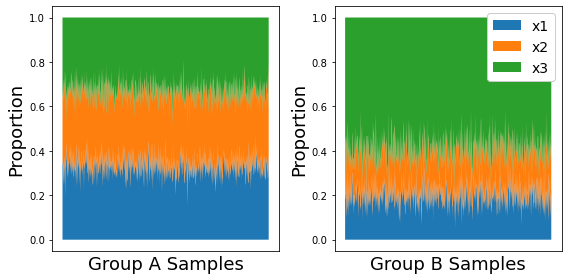

In [2]:
x, y = sim1()
# Let's plot the proportions
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
t = np.arange(np.sum(y==0))
ax[0] = default_barplot(ax[0], x[y], t, ticks=False)
ax[0].set_xlabel('Group A Samples', fontsize=18)
ax[1] = default_barplot(ax[1], x[~y], t, ticks=False)
ax[1].set_xlabel('Group B Samples', fontsize=18)
plt.legend(framealpha=1, fontsize=14)
plt.tight_layout()

Here, we see in Group A there are 3 parts, $x_1, x_2, x_3$ that all have the same proportions.  In Group B, ratio of $x_1, x_2, x_3$ is now 1:1:2.

From this example, can we infer what happened?  In particular
1. Did $x_3$ increase?
2. Did $x_1$ and $x_2$ both decrease?
3. Did option 1 and 2 both simulataneous occur?

In our particular example, we have access to the ground truth.  

See below

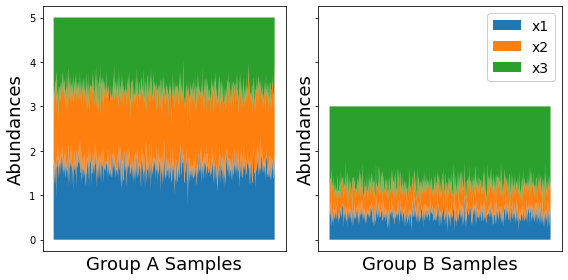

In [3]:
x, y = sim1_truth()

fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
t = np.arange(np.sum(y==0))
ax[0] = default_barplot(ax[0], x[y], t, ticks=False)
ax[0].set_xlabel('Group A Samples', fontsize=18)
ax[0].set_ylabel('Abundances')
ax[1] = default_barplot(ax[1], x[~y], t, ticks=False)
ax[1].set_xlabel('Group B Samples', fontsize=18)
ax[1].set_ylabel('Abundances')
plt.legend(framealpha=1, fontsize=14)
plt.tight_layout()

In this particular example, we see that $x_3$ stayed constant, while $x_1$ and $x_2$ both decreased.

However, amongst the options that were presented earlier -- _all of those scenarios were possible given the information that was presented_.  In fact, we __cannot__ infer which features actually decreased if we only had access to the proportions alone.

To obtain an intuition what we can and cannot say given the data available, we need to have a better understanding what our sample space looks like.  For our 3 proportions $x_1, x_2, x_3$, they satisify the constraint where $x_1 + x_2 + x_3 = 1$, in other words, they live on a plane in the upper quadrant of the real space.  If we were to visualize that plane, it would look like as follows.

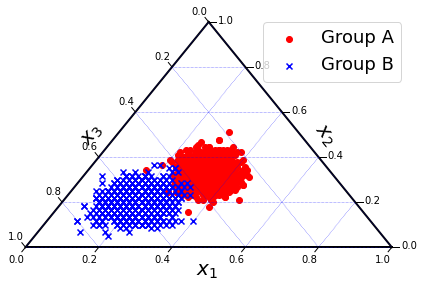

In [16]:
# Reload the original simulation dataset
x, y = sim1()
## Boundary and Gridlines
scale = 1
figure, tax = ternary.figure(scale=scale)
tax = default_ternary_labels(tax)
tax.scatter(x[y, :], marker='o', color='r', label="Group A")
tax.scatter(x[~y, :], marker='x', color='b', label="Group B")
plt.axis('off')
plt.tight_layout()
plt.legend(fontsize=18)

The diagram above is showing the plane in which all the possible values of $x_1, x_2, x_3$ can hold. 

Furthermore, we have visualized the proportions of samples in Group A and Group B in this space.  
As we can see, there is a clear separation between these two groups, but if we cannot determine which features have increased or decreased, how can we determine what is causing the separation??

The key here is understanding the concept of _scale invariance_.  The reason why we are having difficulties inferring which features are changing is because we lost our ability to measure _scale_, which in our case are the totals $N_A$ and $N_B$.  If we cannot measure _scale_, we must engineer quantities that are invariant to it.

One such scale-invariant quantity are ratios, if we compute the ratio of two parts, the totals cancel out.  Specifically, if we consider two features $i$ and $j$ and compute their ratio, the following holds

$$
\frac{p_{A_i} / p_{A_j}}{p_{B_i} / p_{B_j}} = \frac{A_i / A_j}{B_i / B_j}
$$

This approach can scale across higher dimensions if we chose to use feature $j$ as a reference for all of the other variables.  This is the main concept behind the additive log-ratio (ALR) transform which is defined as follows

$$
alr(x) = \bigg[\log \frac{x_1}{x_j} \ldots \log \frac{x_D}{x_j} \bigg]
$$

Here, this transforms a $D$ dimensional vector of proportions to a $D-1$ dimensional vector of log-ratios.  
For a given feature $j$, the corresponding log-ratio is left out (since $\log x_j / x_j = 0$).  In addition to providing scale invariance, computing a log-ratio also removes constraints, since log-ratios can also be represented as negative quantities -- this property turns out to be particularly useful for unconstrained optimization.

We can see this transform in action with the simulation data; by default, we can chose the first feature $x_1$ as the reference, and compute two log ratios $\log(x_2 / x_1)$ and $\log(x_3 / x_1)$.  The transformed data can be visualized as follows.

Text(0, 0.5, '$log(x_3/x_1)$')

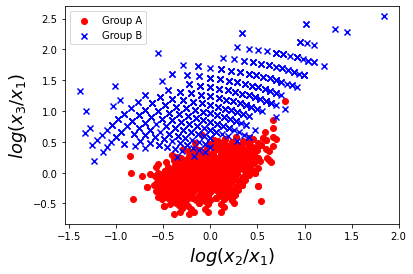

In [5]:
alrx = alr(x)

fig, ax = plt.subplots()

ax.scatter(alrx[y, 0], alrx[y, 1], marker='o', color='r', label="Group A")
ax.scatter(alrx[~y, 0], alrx[~y, 1], marker='x', color='b', label="Group B")
ax.legend(loc=2)
ax.set_xlabel('$log(x_2/x_1)$', fontsize=18)
ax.set_ylabel('$log(x_3/x_1)$', fontsize=18)

Ok, now we can start making statements about what is causing the difference between these two groups!

From eye, we can see that $\log(x_3/x_1)$ is the main differentiator between these two groups.  
The good news is since we are back in unconstrained space, we can apply our favorite statistical methodologies to see if this is indeed true. Below we will apply a t-test to these two log-ratios.

Ttest_indResult(statistic=-79.77127024837979, pvalue=0.0)

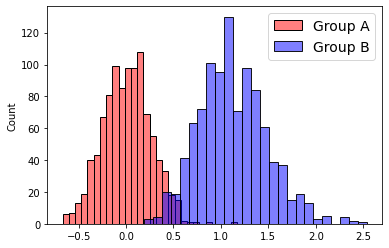

In [17]:
sns.histplot(alrx[y, 1], label='Group A', color='r', alpha=0.5)
sns.histplot(alrx[~y, 1], label='Group B', color='b', alpha=0.5)
plt.legend(fontsize=14)
ttest_ind(alrx[y, 1], alrx[~y, 1])

Ttest_indResult(statistic=-0.2313008972059103, pvalue=0.8171047334821315)

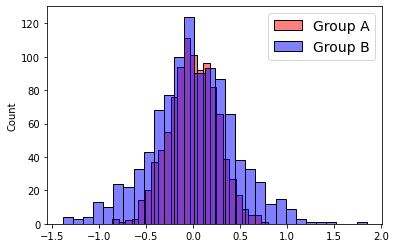

In [18]:
from scipy.stats import ttest_ind
import seaborn as sns
sns.histplot(alrx[y, 0], label='Group A', color='r', alpha=0.5)
sns.histplot(alrx[~y, 0], label='Group B', color='b', alpha=0.5)
plt.legend(fontsize=14)
ttest_ind(alrx[y, 0], alrx[~y, 0])

Indeed our intuition is correct!  $\log(x_3/x_1)$  appears to be explaining the differences whereas $\log(x_2/x_1)$ doesn't.

Now that we have gained some intuition behind the simplicial sample space and the ALR transform, we will need to consider the next steps required to apply this to applications.

One of the major hurdles to applying the ALR transform is the fact that it cannot handle zeros (since $\log(0)$ is undefined).  In the case study, we will show how to get around this by treating the zeros as missing data; the trick here is to use with the inverse ALR transform instead of the ALR transform in a Generalized Linear Modeling framework.